In [1]:
# import required packages
from ipywebrtc import AudioRecorder, CameraStream
import torchaudio
from IPython.display import Audio
import requests
from PIL import Image
from io import BytesIO
import whisper
import matplotlib.pyplot as plt
from flair.data import Sentence
from flair.models import SequenceTagger
from pattern.en import conjugate

In [2]:
# we define a function here to use the api frpm arasaac, and return the image based on the text that we search
# ref: https://arasaac.org/developers/api
def generate_pic(text_to_search, ax):
    search_url = f"https://api.arasaac.org/api/pictograms/en/bestsearch/{text_to_search}"
    search_response = requests.get(search_url)
    search_json = search_response.json()
    if search_json:
        pic_url = f"https://api.arasaac.org/api/pictograms/{search_json[0]['_id']}?download=false"
        pic_response = requests.get(pic_url)
        img = Image.open(BytesIO(pic_response.content))
        ax.imshow(img)
        ax.set_title(text_to_search)
    else:
        ax.set_title(text_to_search)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

In [3]:
# ref: https://medium.com/@harrycblum/record-audio-in-a-jupyter-notebook-da08a88278bb
# here we have a voice recorder in the jupyter notebook
camera = CameraStream(constraints={'audio': True,'video':False})
recorder = AudioRecorder(stream=camera)
recorder

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

In [4]:
# we read the recorded audio
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav file.wav -y -hide_banner -loglevel panic
sig, sr = torchaudio.load("file.wav")
Audio(data=sig, rate=sr)

In [5]:
# we use openai package called wisper to transform the audio into text
model = whisper.load_model("small")
result = model.transcribe("file.wav")
print(result["text"])

/Users/omidreza/opt/anaconda3/lib/python3.9/site-packages/whisper/transcribe.py:78: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


 I am eating an apple.


In [7]:
# we get rid of the commas and dots, maybe in the future there more things to get rid of in a sentence like !, ? ...
res = result["text"].replace(","," ").replace("."," ").split(" ")
new_string = []
for text in res:
    if text:
        new_string.append(text)

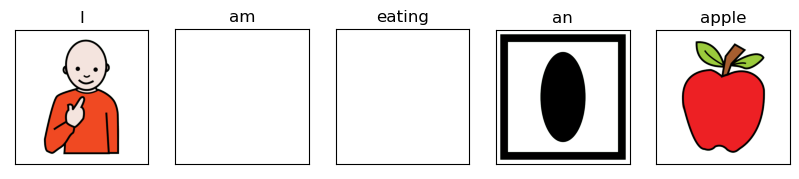

In [8]:
# we generate an initial pictogram
# here we see the am, eating, an having a problem
fig, ax = plt.subplots(1,len(new_string), figsize=(10,1.75))
for i, text in enumerate(new_string):
    generate_pic(text, ax[i])

In [9]:
# work plan
# remove am, is, are, an ... - done with part of speech tagging
# convert verbs to main form eating --> eat - done part of speech tagging and conjugation
# do something for the numbers ... one apple, two apple, ....
# if needed, undrestand some context about the sentence using nlp apis (e.g hugging face)
    # check the uptions that we get from search_json

In [10]:
# functions to work with part of speech tagging package called flair
def getDictFromPOS(texts, labels):
  return [{ "text": t, "label": l } for t, l in zip(texts, labels)]
def getPos(s: Sentence):
  texts = []
  labels = []
  for t in s.tokens:
    for label in t.annotation_layers.keys():
      texts.append(t.text)
      labels.append(t.get_labels(label)[0].value)          
  return texts, labels

In [11]:
# here we use the flair package for part of speech tagging
# ref: https://huggingface.co/flair/pos-english-fast
# ref2: https://huggingface.co/spaces/Wootang01/part_of_speech_categorizer/blob/main/app.py
# refer to above to see what each token means
# part of sentence tagging model 


# load tagger
model = SequenceTagger.load("flair/pos-english")

# make example sentence
s = Sentence(new_string)

# predict NER tags
model.predict(s)

/Users/omidreza/opt/anaconda3/lib/python3.9/site-packages/huggingface_hub/file_download.py:588: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


2022-10-12 09:59:16,660 loading file /Users/omidreza/.flair/models/pos-english/a9a73f6cd878edce8a0fa518db76f441f1cc49c2525b2b4557af278ec2f0659e.121306ea62993d04cd1978398b68396931a39eb47754c8a06a87f325ea70ac63
2022-10-12 09:59:18,656 SequenceTagger predicts: Dictionary with 53 tags: <unk>, O, UH, ,, VBD, PRP, VB, PRP$, NN, RB, ., DT, JJ, VBP, VBG, IN, CD, NNS, NNP, WRB, VBZ, WDT, CC, TO, MD, VBN, WP, :, RP, EX, JJR, FW, XX, HYPH, POS, RBR, JJS, PDT, NNPS, RBS, AFX, WP$, -LRB-, -RRB-, ``, '', LS, $, SYM, ADD


In [12]:
# get POS tags
texts, labels = getPos(s)
print(f"texts: {texts}")
print(f"labels: {labels}")

texts: ['I', 'am', 'eating', 'an', 'apple']
labels: ['PRP', 'VBP', 'VBG', 'DT', 'NN']


In [14]:
# we have a second options for pos tagging in case flair is not favorable
# https://www.nltk.org/book/ch05.html
# https://stackoverflow.com/questions/18942096/how-to-conjugate-a-verb-in-nltk-given-pos-tag
# https://www.nltk.org/api/nltk.tag.html
# from nltk import pos_tag, word_tokenize
# import nltk
# tags = pos_tag(word_tokenize(result["text"])) 
# tags

In [16]:
# here we do the conjugation for verbs
indexes_to_remove = []
# important to use deep copy here
# remember that = (assignment) uses a shallow copy
import copy
new_sentence = copy.deepcopy(texts)
for index, label in enumerate(labels):
    if label in ['VBP', 'DT']:
        indexes_to_remove.append(index)
    elif label == "VBG":
        new_verb = conjugate(new_sentence[index], 
            tense = "INFINITIVE",      # INFINITIVE, PRESENT, PAST, FUTURE
            person = 3,                # 1, 2, 3 or None
            number = "singular",       # SG, PL
            mood = "indicative",       # INDICATIVE, IMPERATIVE, CONDITIONAL, SUBJUNCTIVE
            aspect = "imperfective",   # IMPERFECTIVE, PERFECTIVE, PROGRESSIVE 
            negated = False)
        new_sentence[index] = new_verb
for i in sorted(indexes_to_remove, reverse=True):
    del new_sentence[i]
print(new_sentence)  

['I', 'eat', 'apple']


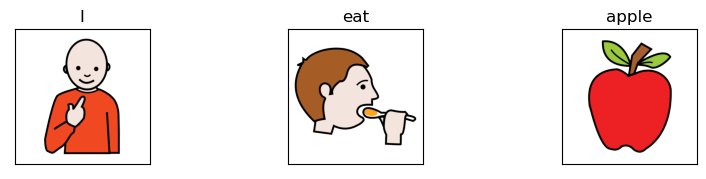

In [17]:
# show the sentence again, now it is better, - need to make a function out of it
fig, ax = plt.subplots(1,len(new_sentence), figsize=(10,1.75))
for i, text in enumerate(new_sentence):
    generate_pic(text, ax[i])

In [ ]:
# need to write something for the numbers now